# Get related data

In [6]:
import os
import sys
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("YourAppName")  \
    .config("spark.executor.memory", "6g") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

transactions = spark.read.parquet("../data/curated/curated_transaction")
transactions = transactions.drop("log_dollar_value", "order_id")
transactions.show(3)

+-------+------------+------------------+--------------+
|user_id|merchant_abn|      dollar_value|order_datetime|
+-------+------------+------------------+--------------+
|  14935| 79417999332|136.06570809815838|    2021-11-26|
|      1| 46451548968| 72.61581642788431|    2021-11-26|
|  14936| 89518629617|3.0783487174439297|    2021-11-26|
+-------+------------+------------------+--------------+
only showing top 3 rows



In [7]:
from pyspark.sql import functions as F

# Group by merchant_abn, order_datetime, and user_id, then sum the dollar_value
transactions_grouped = transactions.groupBy('merchant_abn', 'order_datetime', 'user_id') \
                                   .agg(F.sum('dollar_value').alias('total_dollar_value'))

# Show the result
transactions_grouped.show(5)

24/10/04 22:02:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:02:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:02:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:02:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:02:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:02:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:02:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:02:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:02:45 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+--------------+-------+------------------+
|merchant_abn|order_datetime|user_id|total_dollar_value|
+------------+--------------+-------+------------------+
| 52959528548|    2021-11-26|  14967| 645.6459664910478|
| 41881349154|    2021-11-26|     55| 74.49956514916703|
| 52242018594|    2021-11-26|  15003| 82.04700162722082|
| 81877438808|    2021-11-26|  15101|26.932213280447307|
| 96152467973|    2021-11-26|    187| 62.17978228509556|
+------------+--------------+-------+------------------+
only showing top 5 rows



In [8]:
# Get user fraud rate by date
user_fraud = spark.read.parquet("../data/curated/user_fraud_by_date.parquet")
user_fraud.show(5)

+-------+--------------+--------------------+
|user_id|order_datetime|   fraud_probability|
+-------+--------------+--------------------+
|      1|    2021-03-02| 0.04133541770704879|
|      1|    2021-03-20|0.034287051454195194|
|      1|    2021-03-31|0.035936521365319087|
|      1|    2021-04-03|0.048465117631272196|
|      1|    2021-04-11|0.033987067860580034|
+-------+--------------+--------------------+
only showing top 5 rows



In [9]:
# Get merchants data
merchants = spark.read.parquet("../data/curated/curated_merchants")
merchants = merchants.drop("name", "type", "rev_level")
merchants.show(3)

+------------+---------+
|merchant_abn|take_rate|
+------------+---------+
| 10023283211|     0.18|
| 10142254217|     4.22|
| 10187291046|     3.29|
+------------+---------+
only showing top 3 rows



# Combine the data

In [10]:
# Perform a full outer join between transactions and user_fraud on user_id and order_datetime
transactions_user_fraud = transactions.join(user_fraud, 
                                              on=['user_id', 'order_datetime'], how="inner")

# Show the first 5 rows of the joined result
transactions_user_fraud.show(5)

+-------+--------------+------------+------------------+-------------------+
|user_id|order_datetime|merchant_abn|      dollar_value|  fraud_probability|
+-------+--------------+------------+------------------+-------------------+
|      1|    2021-03-11| 86578477987|23.300617635489033|0.03373424948018306|
|      1|    2021-03-21| 72472909171| 26.84427554025195|0.04324741361124939|
|      1|    2021-03-21| 86010199872|218.49116722954264|0.04324741361124939|
|      1|    2021-04-29| 90796680287|12.246844545453301|0.05392116373834903|
|      1|    2021-04-29| 96680767841| 677.3472120814281|0.05392116373834903|
+-------+--------------+------------+------------------+-------------------+
only showing top 5 rows



In [11]:
merchants = merchants.join(transactions_user_fraud, 
                           on=['merchant_abn'], how="inner")

In [12]:
merchants.show(3)

+------------+---------+-------+--------------+------------------+-------------------+
|merchant_abn|take_rate|user_id|order_datetime|      dollar_value|  fraud_probability|
+------------+---------+-------+--------------+------------------+-------------------+
| 86578477987|     6.43|      1|    2021-03-11|23.300617635489033|0.03373424948018306|
| 72472909171|     6.33|      1|    2021-03-21| 26.84427554025195|0.04324741361124939|
| 86010199872|      2.4|      1|    2021-03-21|218.49116722954264|0.04324741361124939|
+------------+---------+-------+--------------+------------------+-------------------+
only showing top 3 rows



# Calculate expected profit of each merchant by date

In [13]:
# Assume we loss all
recover_rate = 0

# Calculate expected_revenue, expected_loss, and expected_profit
our_profit_by_merchants = merchants.withColumn(
    'expected_revenue', 
    F.col('dollar_value') * (1 - F.col('fraud_probability')) * F.col('take_rate') / 100
).withColumn(
    'expected_loss', 
    F.col('dollar_value') * F.col('fraud_probability') * (1 - F.col('take_rate')) / 100 * (1-recover_rate)
).withColumn(
    'expected_profit', 
    F.col('expected_revenue') + F.col('expected_loss')
)

# Show the results
our_profit_by_merchants.show(5)

+------------+---------+-------+--------------+------------------+-------------------+------------------+--------------------+------------------+
|merchant_abn|take_rate|user_id|order_datetime|      dollar_value|  fraud_probability|  expected_revenue|       expected_loss|   expected_profit|
+------------+---------+-------+--------------+------------------+-------------------+------------------+--------------------+------------------+
| 86578477987|     6.43|      1|    2021-03-11|23.300617635489033|0.03373424948018306|1.4476880203636762|-0.04268136511652821|1.4050066552471479|
| 72472909171|     6.33|      1|    2021-03-21| 26.84427554025195|0.04324741361124939|1.6257547727517394|-0.06187839359181...|1.5638763791599235|
| 86010199872|      2.4|      1|    2021-03-21|218.49116722954264|0.04324741361124939| 5.017007943757062| -0.1322884993255679| 4.884719444431495|
| 90796680287|     5.97|      1|    2021-04-29|12.246844545453301|0.05392116373834903|0.6917128576863532|-0.03282009488217..

In [14]:
our_profit_by_merchants = our_profit_by_merchants.drop("expected_loss", "expected_revenue", "fraud_probability", "dollar_value", "take_rate")
our_profit_by_merchants.show(3)

+------------+-------+--------------+------------------+
|merchant_abn|user_id|order_datetime|   expected_profit|
+------------+-------+--------------+------------------+
| 86578477987|      1|    2021-03-11|1.4050066552471479|
| 72472909171|      1|    2021-03-21|1.5638763791599235|
| 86010199872|      1|    2021-03-21| 4.884719444431495|
+------------+-------+--------------+------------------+
only showing top 3 rows



## Get total expected profit and user number by merchant per date

In [15]:
# Group by merchant_abn and order_datetime, then aggregate by summing expected_profit and counting users
our_profit_by_merchants = our_profit_by_merchants.groupBy('merchant_abn', 'order_datetime') \
                                           .agg(
                                                F.sum('expected_profit').alias('total_expected_profit'),
                                                F.count('user_id').alias('user_count')
                                           )

# Show the results
our_profit_by_merchants.show(5)

24/10/04 22:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:31 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+--------------+---------------------+----------+
|merchant_abn|order_datetime|total_expected_profit|user_count|
+------------+--------------+---------------------+----------+
| 68216911708|    2021-05-06|    313.8787374887032|       287|
| 46804135891|    2021-10-08|    312.9468966885478|       352|
| 19933438190|    2021-04-28|    17.73021713045588|        69|
| 79283124876|    2022-08-31|   132.07014947731156|         6|
| 90612658132|    2021-12-21|   10.383749712347287|         3|
+------------+--------------+---------------------+----------+
only showing top 5 rows



# Impute missing combinations of merchant and datetime with 0

In [16]:
from pyspark.sql import SparkSession
from datetime import datetime, timedelta

# Start and end date
start_date = datetime.strptime("2021-02-28", "%Y-%m-%d")
end_date = datetime.strptime("2022-10-26", "%Y-%m-%d")

# Generate all dates between the start and end date
date_list = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end_date - start_date).days + 1)]

# Create a DataFrame with the date range
date_range_df = spark.createDataFrame([(d,) for d in date_list], ["order_datetime"])

# Get distinct merchant_abn values
merchant_abns = our_profit_by_merchants.select("merchant_abn").distinct()

# Cross join merchant_abn with the date range to get all combinations
all_combinations = merchant_abns.crossJoin(date_range_df)

# Left join the full combination with merchants_profit_grouped
our_profit_by_merchants = all_combinations.join(
    our_profit_by_merchants,
    on=["merchant_abn", "order_datetime"],
    how="left"
)

# Impute missing values (fill missing total_expected_profit and user_count with 0)
our_profit_by_merchants = our_profit_by_merchants.fillna({'total_expected_profit': 0, 'user_count': 0})

# Show the final result
our_profit_by_merchants.show(3)

24/10/04 22:03:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:03:56 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+--------------+---------------------+----------+
|merchant_abn|order_datetime|total_expected_profit|user_count|
+------------+--------------+---------------------+----------+
| 73256306726|    2021-10-11|     99.8786126256386|         8|
| 73256306726|    2022-08-07|    138.6683876331731|        11|
| 83412691377|    2021-12-25|    17.90348554305494|        19|
+------------+--------------+---------------------+----------+
only showing top 3 rows



# Forcasting future profit and user number for each merchant with seasonal ARIMA

# SARIMAX Model Overview

The **SARIMAX** model (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) is chosen for forecasting because it is designed for time series data. It incorporates several key components:

- **Auto-regression (AR)**: Uses past values of the target variable to predict future values.
- **Moving Average (MA)**: Utilizes past forecast errors to make predictions.
- **Integrated (I)**: Applies differencing to the series in order to make it stationary.
- **Seasonality**: Captures seasonal patterns in the data (e.g., weekly, monthly seasonality).

### Hyperparameters of the SARIMAX Model

The SARIMAX model requires several hyperparameters to be defined:

- **p**: The number of lag observations in the AR model (the number of previous terms used for prediction).
- **d**: The number of differences applied to make the time series stationary.
- **q**: The number of lagged forecast errors in the MA model.
- **P, D, Q, m**: These are the seasonal components:
  - **P**: Seasonal autoregressive order.
  - **D**: Seasonal differencing order.
  - **Q**: Seasonal moving average order.
  - **m**: The number of observations per season.

These parameters allow the model to capture both short-term and seasonal patterns in the data, making it ideal for time series forecasting.

## We first find out the best set of hyperparameters

### Get the average profit and user number across all user by date. then treat it as a representative merchant for finding the best parameters and visualizing

In [17]:
# Aggregate total expected profit and user count by order_datetime
aggregated_by_date = our_profit_by_merchants.groupBy('order_datetime') \
                                            .agg(F.avg('total_expected_profit').alias('avg_total_expected_profit'),
                                                 F.avg('user_count').alias('avg_user_count'))

aggregated_df = aggregated_by_date.toPandas()
aggregated_df['order_datetime'] = pd.to_datetime(aggregated_df['order_datetime'])
aggregated_df = aggregated_df.set_index('order_datetime').asfreq('D')  # Set frequency to daily (D)

24/10/04 22:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:04:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:04:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:04:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:04:25 WARN RowBasedKeyValueBatch: Calling spill() on

In [18]:
aggregated_df.head(3)

,avg_total_expected_profit,avg_user_count
order_datetime,,
2021-02-28,23.164038,4.085496
2021-03-01,20.724600,3.624936
2021-03-02,20.613571,3.690076


## Check for non stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(aggregated_df['avg_total_expected_profit'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.566759271825498
p-value: 0.1000638898235669


In [20]:
diff_data = aggregated_df['avg_total_expected_profit'].diff().dropna()
result_diff = adfuller(diff_data)
print(f'ADF Statistic after differencing: {result_diff[0]}')
print(f'p-value after differencing: {result_diff[1]}')

ADF Statistic after differencing: -7.394353440959454
p-value after differencing: 7.849204763100884e-11


### Apply grid search for best hyperparameter using AIC

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Define SARIMA model fitting function
def fit_sarima(order, seasonal_order, train_data):
    try:
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        return model_fit
    except Exception as e:
        print(f"Error fitting model with order={order} and seasonal_order={seasonal_order}: {e}")
        return None

# Define the parameter grid for grid search with d=1 fixed
param_grid = {
    'order': [(p, 1, q) for p in range(1, 2) for q in range(0, 2)],  # d is set to 1
    'seasonal_order': [(P, 1, Q, 7) for P in range(2, 3) for Q in range(0, 2) ], 
}

# Initialize variables to track the best model and lowest AIC
best_aic = np.inf
best_params = None
best_model = None

# Track progress
total_iterations = len(ParameterGrid(param_grid))
iteration = 0

# Perform grid search to find the best parameters
for params in ParameterGrid(param_grid):
    iteration += 1
    print(f"Fitting model {iteration}/{total_iterations} with parameters: {params}")

    model = fit_sarima(params['order'], params['seasonal_order'], aggregated_df['avg_total_expected_profit'])
    if model:
        print(f"Model AIC: {model.aic}")
        if model.aic < best_aic:
            best_aic = model.aic
            best_params = params
            best_model = model

# Print the best parameters and AIC
print(f"\nBest AIC: {best_aic}")
print(f"Best parameters: {best_params}")

Fitting model 1/4 with parameters: {'order': (1, 1, 0), 'seasonal_order': (2, 1, 0, 7)}
Model AIC: 2940.4432604757103
Fitting model 2/4 with parameters: {'order': (1, 1, 0), 'seasonal_order': (2, 1, 1, 7)}
Model AIC: 2826.8497582197438
Fitting model 3/4 with parameters: {'order': (1, 1, 1), 'seasonal_order': (2, 1, 0, 7)}
Model AIC: 2935.0581052060397
Fitting model 4/4 with parameters: {'order': (1, 1, 1), 'seasonal_order': (2, 1, 1, 7)}
Model AIC: 2820.4538953142364

Best AIC: 2820.4538953142364
Best parameters: {'order': (1, 1, 1), 'seasonal_order': (2, 1, 1, 7)}


### Visualize next 6 month forecast

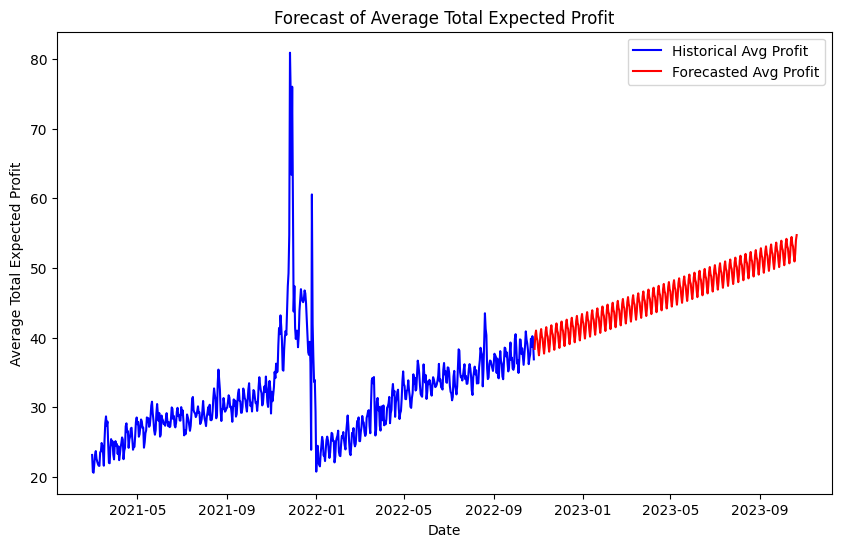

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract date and profit from the historical data up to 2022-10-26
historical_data = aggregated_df[['avg_total_expected_profit']].loc[:'2022-10-26']

# Create a new DataFrame for the forecasted values
forecast = best_model.get_forecast(steps=360)
forecast_profit = forecast.predicted_mean
forecast_dates = pd.date_range(start='2022-10-27', periods=360, freq='D')

# Create the forecast DataFrame
forecast_df_profit = pd.DataFrame(forecast_profit, index=forecast_dates, columns=['predicted_mean'])

# Rename 'predicted_mean' to 'avg_total_expected_profit' to match historical data
forecast_df_profit.rename(columns={'predicted_mean': 'avg_total_expected_profit'}, inplace=True)

# Ensure the forecast DataFrame index has the same name as the historical index
forecast_df_profit.index.name = 'order_datetime'

# Concatenate historical and forecast data
combined_data = pd.concat([historical_data, forecast_df_profit])

# Plot the historical data in blue and the forecast data in red
plt.figure(figsize=(10, 6))

# Plot historical data in blue
plt.plot(combined_data.loc[:'2022-10-26'].index, combined_data.loc[:'2022-10-26', 'avg_total_expected_profit'], label="Historical Avg Profit", color='blue')

# Plot forecast data in red
plt.plot(combined_data.loc['2022-10-27':].index, combined_data.loc['2022-10-27':, 'avg_total_expected_profit'], label="Forecasted Avg Profit", color='red')

# Add labels and title
plt.title("Forecast of Average Total Expected Profit")
plt.xlabel('Date')
plt.ylabel('Average Total Expected Profit')
plt.legend()
plt.show()

# Now train Arima model for all records and get predicted results

In [23]:
from pyspark.sql.types import FloatType
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from math import ceil
import os

# Suppress the ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def forecast_profit(merchant_data_pd):
    try:
        # Convert to pandas DataFrame and set index
        merchant_data_pd = pd.DataFrame(merchant_data_pd, columns=['order_datetime', 'total_expected_profit'])
        merchant_data_pd['order_datetime'] = pd.to_datetime(merchant_data_pd['order_datetime'])
        merchant_data_pd.set_index('order_datetime', inplace=True)
        merchant_data_pd = merchant_data_pd.sort_index()

        # Set frequency to 'D' (daily) or another appropriate frequency
        merchant_data_pd = merchant_data_pd.asfreq('D')  # Adjust frequency if necessary

        # Check if the merchant has sufficient data to fit the model
        if len(merchant_data_pd) < 2:
            return None

        # Train SARIMAX model
        model = sm.tsa.statespace.SARIMAX(
            merchant_data_pd['total_expected_profit'],
            order=(1, 1, 1),
            seasonal_order=(2, 1, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)

        # Check for convergence issues
        if not result.mle_retvals['converged']:
            return None

        # Forecast the next 6 months (180 days)
        forecast = result.get_forecast(steps=180)
        forecast_profit = forecast.predicted_mean

        # Sum of the forecasted total profit for 6 months
        total_forecasted_profit = float(forecast_profit.sum())

        return total_forecasted_profit
    except Exception as e:
        return None

# Register the function as a UDF (User Defined Function)
forecast_udf = F.udf(forecast_profit, FloatType())

# Create the folder if it doesn't exist
output_folder = "../data/curated/profit_per_merchants"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Collect unique merchant IDs
merchant_ids = our_profit_by_merchants.select('merchant_abn').distinct().rdd.flatMap(lambda x: x).collect()
total_merchants = len(merchant_ids)
batch_size = 400  # Adjust the batch size as needed
num_batches = ceil(total_merchants / batch_size)

for batch_num in range(num_batches):
    start_index = batch_num * batch_size
    end_index = min((batch_num + 1) * batch_size, total_merchants)
    batch_merchants = merchant_ids[start_index:end_index]
    
    # Filter data for the current batch of merchants
    batch_df = our_profit_by_merchants.filter(F.col('merchant_abn').isin(batch_merchants))
    
    # Apply the UDF to group data and forecast for each merchant
    merchant_forecasts = batch_df.groupBy('merchant_abn').agg(
        F.collect_list(F.struct('order_datetime', 'total_expected_profit')).alias('merchant_data')
    ).withColumn('predict_6_months_total_profit', forecast_udf('merchant_data'))
    
    # Store results for the current batch in Parquet format
    batch_output_path = os.path.join(output_folder, f'batch_{batch_num + 1}.parquet')
    merchant_forecasts.select('merchant_abn', 'predict_6_months_total_profit') \
                      .write.mode('overwrite').parquet(batch_output_path)
    
    # Update and print progress
    processed_merchants = end_index
    print(f"Processed and stored batch {batch_num + 1}/{num_batches}: {processed_merchants} of {total_merchants} merchants processed.")

24/10/04 22:05:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:05:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:05:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:05:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:05:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:05:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:05:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:05:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:05:29 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 1/10: 400 of 3930 merchants processed.


24/10/04 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:12:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:12:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:12:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:12:34 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 2/10: 800 of 3930 merchants processed.


24/10/04 22:18:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:18:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:18:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:18:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:18:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:18:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:18:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:18:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:18:53 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 3/10: 1200 of 3930 merchants processed.


24/10/04 22:24:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:24:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:24:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:24:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:24:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:24:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:24:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:24:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:24:59 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 4/10: 1600 of 3930 merchants processed.


24/10/04 22:32:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:32:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:32:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:32:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:32:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:32:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:32:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:32:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:32:33 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 5/10: 2000 of 3930 merchants processed.


24/10/04 22:39:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:39:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:39:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:39:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:39:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:39:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:39:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:39:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:39:08 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 6/10: 2400 of 3930 merchants processed.


24/10/04 22:45:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:45:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:45:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:45:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:45:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:45:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:45:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:45:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:45:45 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 7/10: 2800 of 3930 merchants processed.


24/10/04 22:51:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:51:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:51:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:51:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:51:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:51:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:51:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:51:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:51:19 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 8/10: 3200 of 3930 merchants processed.


24/10/04 22:58:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:58:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:58:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:58:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:58:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:58:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:58:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:58:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 22:58:07 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 9/10: 3600 of 3930 merchants processed.


24/10/04 23:04:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 23:04:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 23:04:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 23:04:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 23:04:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 23:04:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 23:04:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 23:04:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/04 23:04:34 WARN RowBasedKeyValueBatch: Calling spill() on

Processed and stored batch 10/10: 3930 of 3930 merchants processed.


In [25]:
# Define the output folder path
output_folder = "../data/curated/profit_per_merchants"

# Read all Parquet files from the directory
profit_df = spark.read.parquet(os.path.join(output_folder, "*.parquet"))

# Show the combined result
profit_df.show()

+------------+-----------------------------+
|merchant_abn|predict_6_months_total_profit|
+------------+-----------------------------+
| 10255988167|                    4401.4478|
| 10430380319|                     1007.187|
| 11215815177|                    18600.148|
| 11411018019|                     41.53692|
| 11563852275|                    3258.6406|
| 11961681734|                    4044.7485|
| 12426913844|                     845.3283|
| 12438697459|                    11490.878|
| 12888399565|                     7675.888|
| 13061606045|                    365.83298|
| 13663374533|                    1198.0724|
| 13900607417|                      235.471|
| 14420598156|                    572.71265|
| 14666015798|                    999.37427|
| 14820207872|                     889.2709|
| 14878918457|                     615.5693|
| 14961279222|                   10032.2295|
| 15302620892|                     696.1319|
| 15577036924|                     298.5855|
| 16199101

In [26]:
# Check the number of rows and rows with null values in 'predict_6_months_total_profit'
row_count = profit_df.count()
null_count = profit_df.filter(F.col('predict_6_months_total_profit').isNull()).count()

row_count, null_count

(3930, 34)

### Since the number or rows with null value is small. these are merchant likely having 0 revenues for days or have revenues fluctuate highly. Thus MLE fail to converge. but they account for less then 1% so i will remove them. Otherwise we can impute these with last 6 months revenue.

In [27]:
# Remove rows with null values in 'predict_6_months_total_profit'
cleaned_profit_df = profit_df.filter(F.col('predict_6_months_total_profit').isNotNull())

# Resave the cleaned dataset 
cleaned_output_folder = "../data/curated/cleaned_profit_per_merchants"
cleaned_profit_df.write.mode('overwrite').parquet(cleaned_output_folder)

# Print the number of rows after cleaning
cleaned_row_count = cleaned_profit_df.count()
print(f"Number of rows after removing null values: {cleaned_row_count}")

Number of rows after removing null values: 3896
